In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
import os

# Import necessary PyTorch libraries
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import numpy as np

In [ ]:
import os
def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    print("Downloading the data...")
    !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
    print("Dataset downloaded!")
    print("Extracting data..")
    !tar xzvf food-101.tar.gz
    print("Extraction done!")

In [ ]:
get_data_extract()

Streaming output truncated to the last 5000 lines.
food-101/images/cannoli/1767088.jpg
food-101/images/cannoli/3201965.jpg
food-101/images/cannoli/3778102.jpg
food-101/images/cannoli/2674065.jpg
food-101/images/cannoli/1169899.jpg
food-101/images/cannoli/1378086.jpg
food-101/images/cannoli/803909.jpg
food-101/images/cannoli/1067240.jpg
food-101/images/cannoli/3002709.jpg
food-101/images/cannoli/2612632.jpg
food-101/images/cannoli/3627612.jpg
food-101/images/cannoli/1798703.jpg
food-101/images/cannoli/560632.jpg
food-101/images/cannoli/512468.jpg
food-101/images/cannoli/2331523.jpg
food-101/images/cannoli/3118302.jpg
food-101/images/cannoli/1499412.jpg
food-101/images/cannoli/1557459.jpg
food-101/images/cannoli/146566.jpg
food-101/images/cannoli/96922.jpg
food-101/images/cannoli/1699562.jpg
food-101/images/cannoli/730051.jpg
food-101/images/cannoli/2177977.jpg
food-101/images/cannoli/2767028.jpg
food-101/images/cannoli/6564.jpg
food-101/images/cannoli/553447.jpg
food-101/images/cannoli/

In [ ]:
!ls food-101/

images	license_agreement.txt  meta  README.txt


In [ ]:
import os
os.listdir('food-101/images')

['gyoza',
 'croque_madame',
 'bruschetta',
 'fried_calamari',
 'panna_cotta',
 'tuna_tartare',
 'pancakes',
 'scallops',
 'spring_rolls',
 'miso_soup',
 'hamburger',
 'strawberry_shortcake',
 'donuts',
 'nachos',
 'apple_pie',
 'french_onion_soup',
 'red_velvet_cake',
 'spaghetti_bolognese',
 'garlic_bread',
 'cup_cakes',
 'chocolate_cake',
 'ravioli',
 'shrimp_and_grits',
 'hummus',
 'crab_cakes',
 'seaweed_salad',
 'beignets',
 'ice_cream',
 'lobster_roll_sandwich',
 'bread_pudding',
 'dumplings',
 'club_sandwich',
 'churros',
 'beef_tartare',
 'eggs_benedict',
 'poutine',
 'ramen',
 'guacamole',
 'caprese_salad',
 'chicken_wings',
 'french_toast',
 'oysters',
 'cannoli',
 'deviled_eggs',
 'hot_dog',
 'pizza',
 'clam_chowder',
 'frozen_yogurt',
 'lobster_bisque',
 'prime_rib',
 'gnocchi',
 'cheese_plate',
 'pulled_pork_sandwich',
 'beef_carpaccio',
 'pho',
 'filet_mignon',
 'chicken_curry',
 'takoyaki',
 'omelette',
 'sushi',
 'greek_salad',
 'sashimi',
 'fish_and_chips',
 'beet_sala

In [ ]:
!ls food-101/meta

classes.txt  labels.txt  test.json  test.txt  train.json  train.txt


In [ ]:
#List of Food items that we will be training the model for
food_items = ["omelette", "macarons", "macaroni_and_cheese", "samosa", "cup_cakes", "pizza", "donuts", "prime_rib", "hot_dog", "caesar_salad"]
# print(len(food_items))

#Override find_classes of the datasets class to only include
#the 10 categories of food items we are interested in

#Override find_classes
def find_classes(self, directory: str):
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry for entry in food_items if(os.path.isdir(os.path.join(directory, entry))))

    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")

    # 3. Create a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

datasets.ImageFolder._find_classes = find_classes

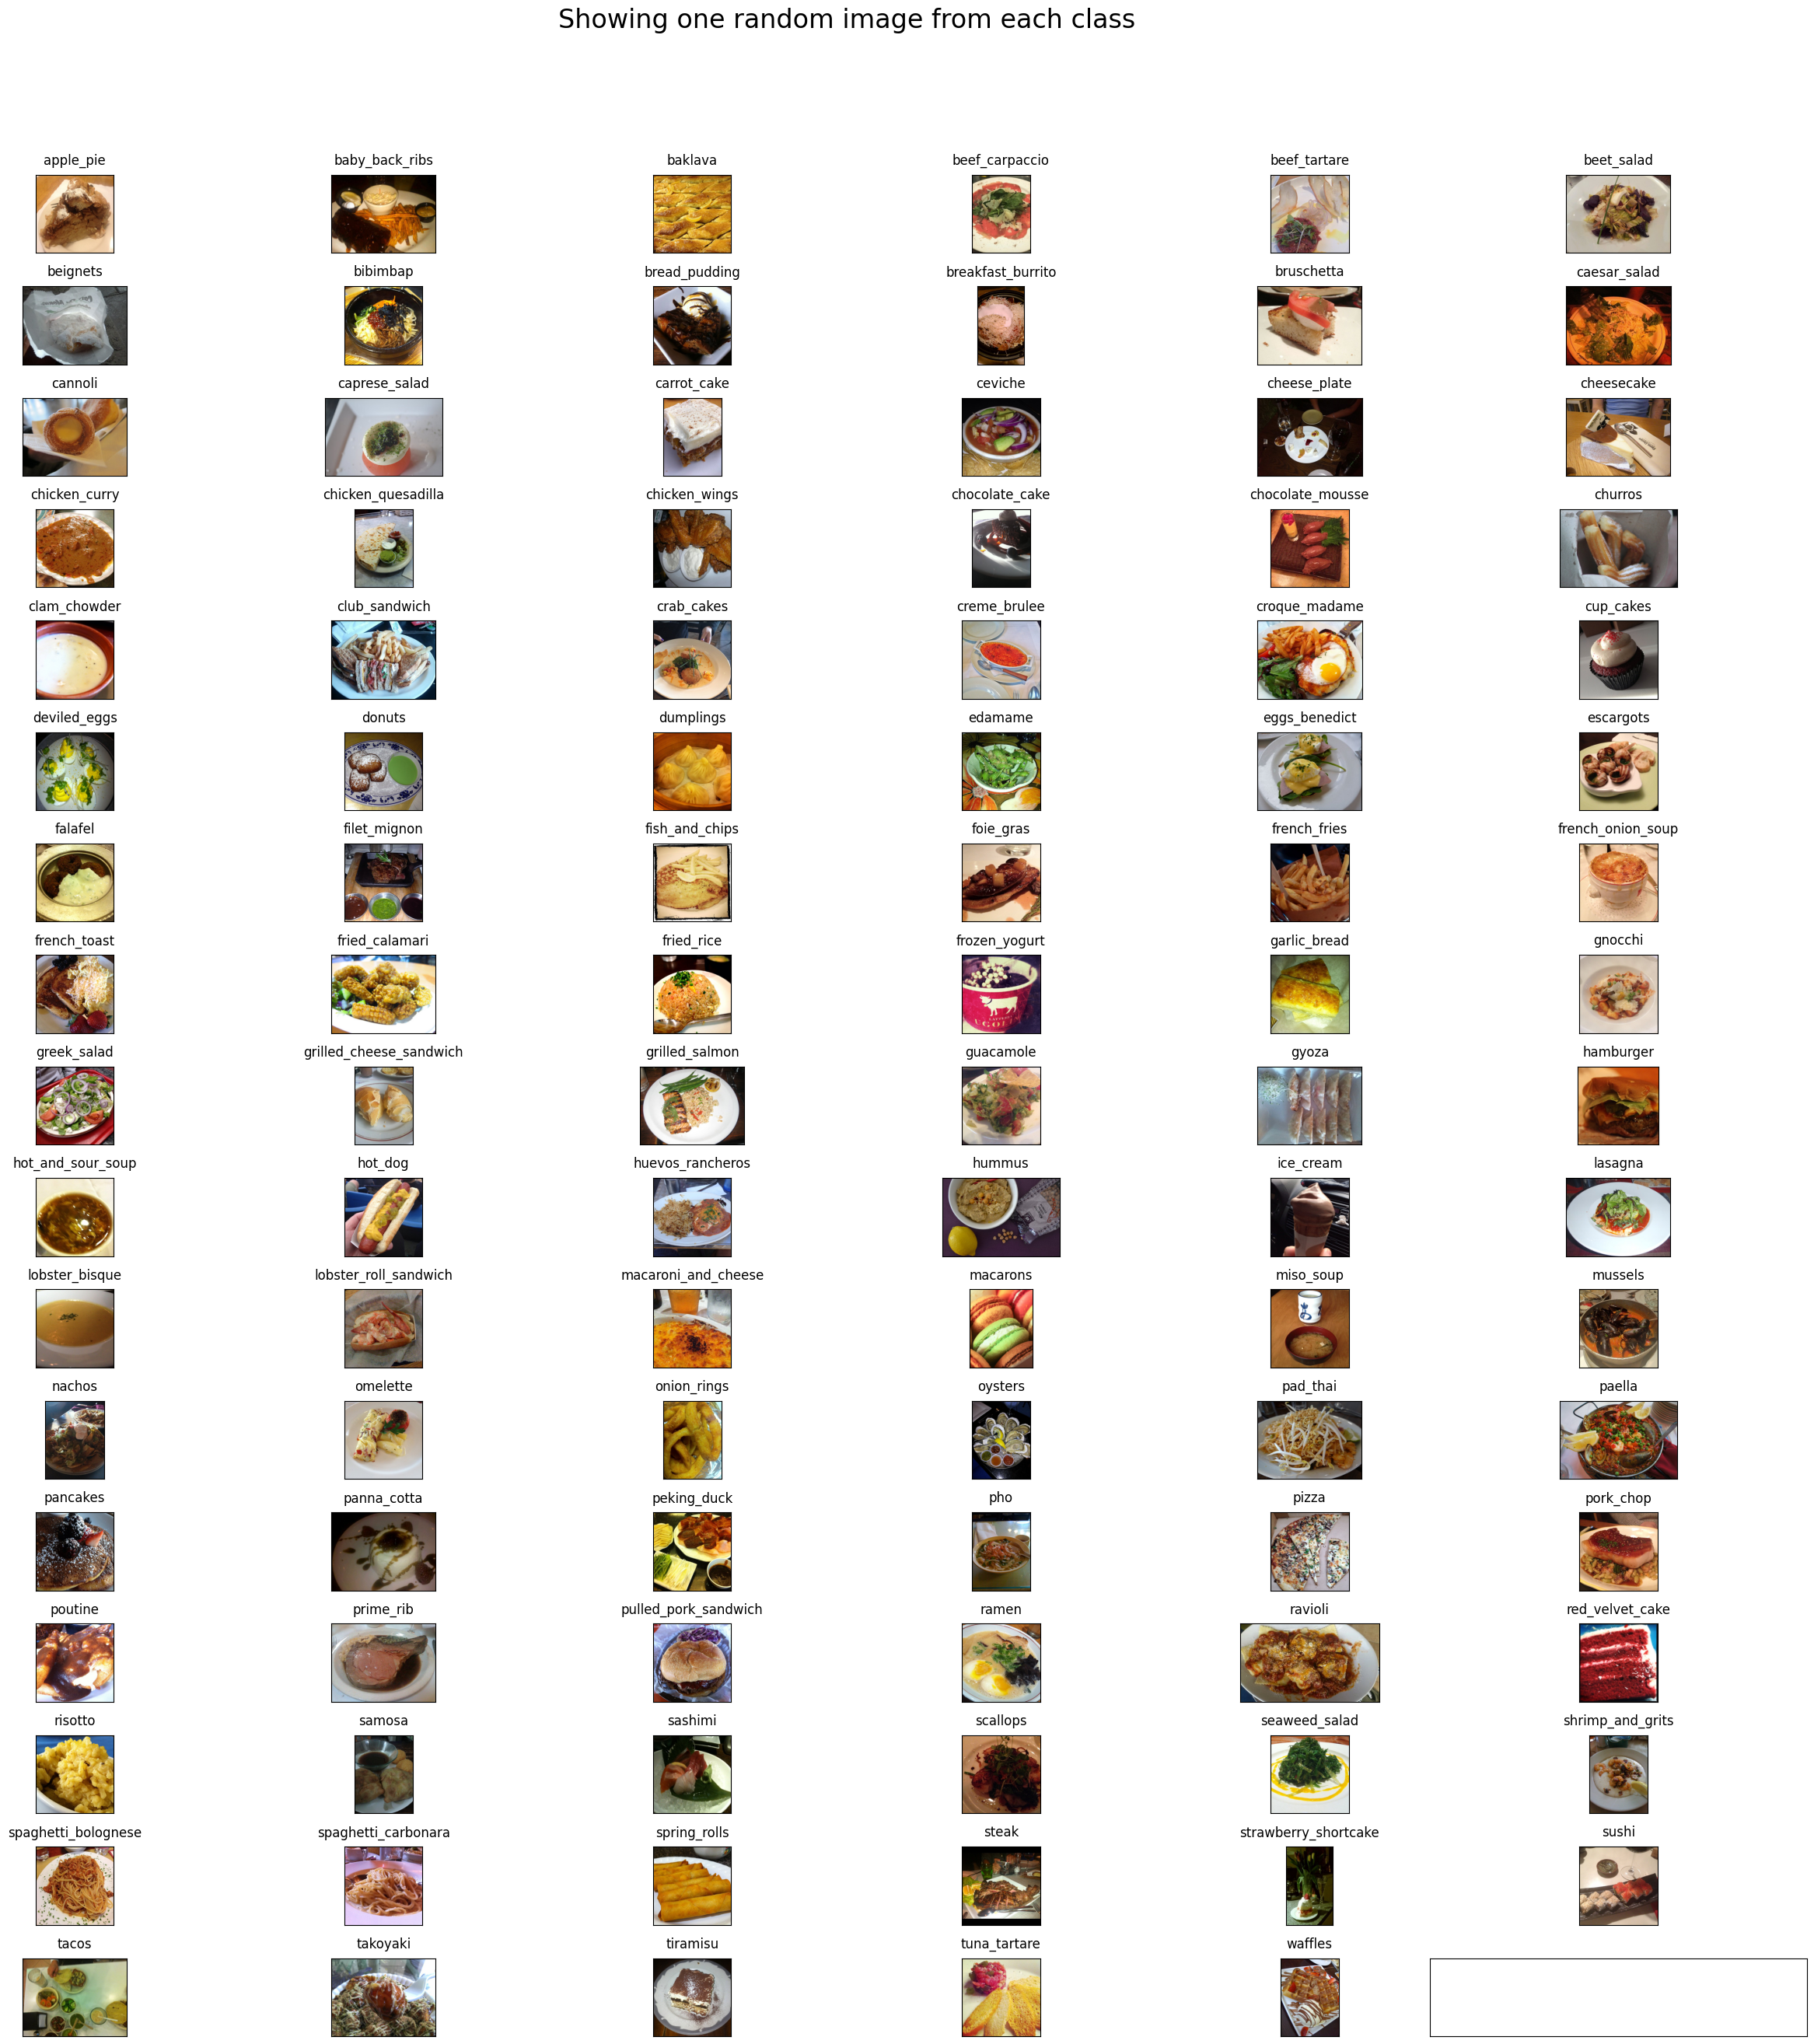

In [ ]:
# Visualize the data, showing one image per class from 101 classes
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "food-101/images/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id]
      food_id += 1
    except:
      break
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)

plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()
# https://matplotlib.org/users/tight_layout_guide.html


In [ ]:
# Check whether GPU is available and if it is then use GPU
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
# Data augmentation
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(45),
                                       transforms.ColorJitter(),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])

# Use 5-crop for Test Time Augmentation
test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.FiveCrop(224),
                                      transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
                                      transforms.Lambda(lambda crops: torch.stack([transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])(crop) for crop in crops]))])

# Load the datasets with ImageFolder
train_data = datasets.ImageFolder("food-101/train", transform=train_transforms)
test_data = datasets.ImageFolder("food-101/test", transform=test_transforms)

# Using the image datasets and the tranforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size= 64, shuffle = True)

In [ ]:
# Load the ResNet-50 model pretrained on ImageNet
model = models.resnet50(pretrained=True)
print(model)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 87.5MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Freeze the initial layers
for param in model.parameters():
  param.requies_grad = False

# Replace the final fully connected layer with new fully connected layer (randomly initialized weights)
# that outputs 101 units (based on our dataset)
classifier = nn.Linear(2048, 101)
model.fc = classifier
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent with momentum)
optimizer = optim.SGD(model.fc.parameters(), lr=0.02, momentum=0.9)

# specify learning rate scheduler (if there is no further decrease in loss for next 3 epochs
# then lower the learning rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 3)

In [ ]:
# Move the model to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

# number of epochs to train the model
n_epochs = 6

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):
    # keep track of training and validation loss
    train_loss = 0.0
    train_accuracy = 0.0
    valid_loss = 0.0
    val_accuracy = 0.0

    ###################
    # train the model #
    ###################
    model.train()
    count = 0
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        # Calculate training accuracy
        top_p, top_class = output.topk(1, dim=1)
        equals = top_class == target.view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()*data.size(0)
        count+=1
        if(count%10)==0:
            print("Training loader count ", count)

    print("Training complete for epoch ", epoch)

    ######################
    # validate the model #
    ######################
    model.eval()
    count = 0
    with torch.no_grad():
        for data, target in test_loader:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            ## For 5-crop Testing
            input_var = torch.autograd.Variable(data)
            target_var = torch.autograd.Variable(target)
            bs, ncrops, c, h, w = input_var.size()
            # forward pass: compute predicted outputs by passing inputs to the model
            temp_output = model(input_var.view(-1, c, h, w))
            output = temp_output.view(bs, ncrops, -1).mean(1)
            # calculate the batch loss
            loss = criterion(output, target_var)
            # update average validation loss
            valid_loss += loss.item()*data.size(0)
            # Calculate validation accuracy
            top_p, top_class = output.topk(1, dim=1)
            equals = top_class == target.view(*top_class.shape)
            val_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()*data.size(0)
            count+=1
            if(count%10)==0:
                print("Validation loader count ", count)

    print("Validation complete for epoch ", epoch)

    # calculate average losses and accuracies
    train_loss = train_loss/len(train_loader.dataset)
    train_accuracy = train_accuracy/len(train_loader.dataset)
    valid_loss = valid_loss/len(test_loader.dataset)
    val_accuracy = val_accuracy/len(test_loader.dataset)
    # Learning rate scheduler step
    scheduler.step(valid_loss)

    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.4f} \tTraining Accuracy: {:.4f} \tValidation Loss: {:.4f} \tValidation Accuracy: {:.4f}'.format(
        epoch, train_loss, train_accuracy, valid_loss, val_accuracy))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))

        checkpoint = {"model": model,
                      "criterion": criterion,
                      "epochs": epoch,
                      "optimizer_state": optimizer.state_dict(),
                      "model_state": model.state_dict(),
                      "valid_loss_min": valid_loss}

        # save model
        torch.save(checkpoint, 'res50model.pth')
        valid_loss_min = valid_loss

Training loader count  10
Training loader count  20
Training loader count  30
Training loader count  40
Training loader count  50
Training loader count  60
Training loader count  70
Training loader count  80
Training loader count  90
Training loader count  100
Training loader count  110
Training loader count  120
Training loader count  130
Training loader count  140
Training loader count  150
Training loader count  160
Training loader count  170
Training loader count  180
Training loader count  190
Training loader count  200
Training loader count  210
Training loader count  220
Training loader count  230
Training loader count  240
Training loader count  250
Training loader count  260
Training loader count  270
Training loader count  280
Training loader count  290
Training loader count  300
Training loader count  310
Training loader count  320
Training loader count  330
Training loader count  340
Training loader count  350
Training loader count  360
Training loader count  370
Training l

KeyboardInterrupt: ignored

In [ ]:
from shutil import copy
def prepare_data(filepath, src, dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [ ]:
# Prepare train dataset by copying images from food-101/images to food-101/train using the file train.txt
print("Creating train data...")
prepare_data('food-101/meta/train.txt', 'food-101/images', 'food-101/train')

Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying im

In [ ]:


# Prepare test data by copying images from food-101/images to food-101/test using the file test.txt
print("Creating test data...")
prepare_data('food-101/meta/test.txt', 'food-101/images', 'food-101/test')



Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying ima

In [ ]:
print("Total number of samples in train folder")
!find food-101/train -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
75750


In [ ]:
print("Total number of samples in test folder")
!find food-101/test -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
25250


In [ ]:
# Helper function to select n random food classes
import random
def pick_n_random_classes(n):
  food_list = []
  random_food_indices = random.sample(range(len(foods_sorted)),n) # We are picking n random food classes
  for i in random_food_indices:
    food_list.append(foods_sorted[i])
  food_list.sort()
  print("These are the randomly picked food classes we will be training the model on...\n", food_list)
  return food_list



In [ ]:
# Lets try with more classes than just 3. Also, this time lets randomly pick the food classes
n = 11
food_list = pick_n_random_classes(11)

In [ ]:
# Create the new data subset of n classes
print("Creating training data folder with new classes...")
dataset_mini(food_list, src_train, dest_train)

In [ ]:
print("Total number of samples in train folder")
!find food-101/train_mini -type d -or -type f -printf '.' | wc -c

In [ ]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

In [ ]:
print("Total number of samples in test folder")
!find food-101/test_mini -type d -or -type f -printf '.' | wc -c

In [ ]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import numpy as np


In [ ]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')



CUDA is available!  Training on GPU ...


In [ ]:
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.RandomRotation(45),
                                       transforms.RandomAffine(45),
                                       transforms.ColorJitter(),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])

# Use 10-crop for Test Time Augmentation
test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.TenCrop(224),
                                      transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
                                      transforms.Lambda(lambda crops: torch.stack([transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])(crop) for crop in crops]))])

# Load the datasets with ImageFolder
train_data = datasets.ImageFolder("./food-101/train_mini", transform=train_transforms)
test_data = datasets.ImageFolder("./food-101/test_mini", transform=test_transforms)

# Using the image datasets and the tranforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size= 64, shuffle = True)


In [ ]:
print('Number of training images: ', len(train_data))
print('Number of testing images: ', len(test_data))

with open('food-101/meta/classes.txt', 'r') as txt:
    classes = [l.strip() for l in txt.readlines()]
print('Number of classes: ', len(classes))

# Analyzing the shape of one batch
train_images, train_labels = next(iter(train_loader))
test_images, test_labels = next(iter(test_loader))

print('Shape of first batch of training images: ', train_images.shape)
print('Shape of first batch of test images: ', test_images.shape) # 5-D array because of 10 crops

Number of training images:  75750
Number of testing images:  25250
Number of classes:  101
Shape of first batch of training images:  torch.Size([64, 3, 224, 224])
Shape of first batch of test images:  torch.Size([64, 10, 3, 224, 224])


In [ ]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator


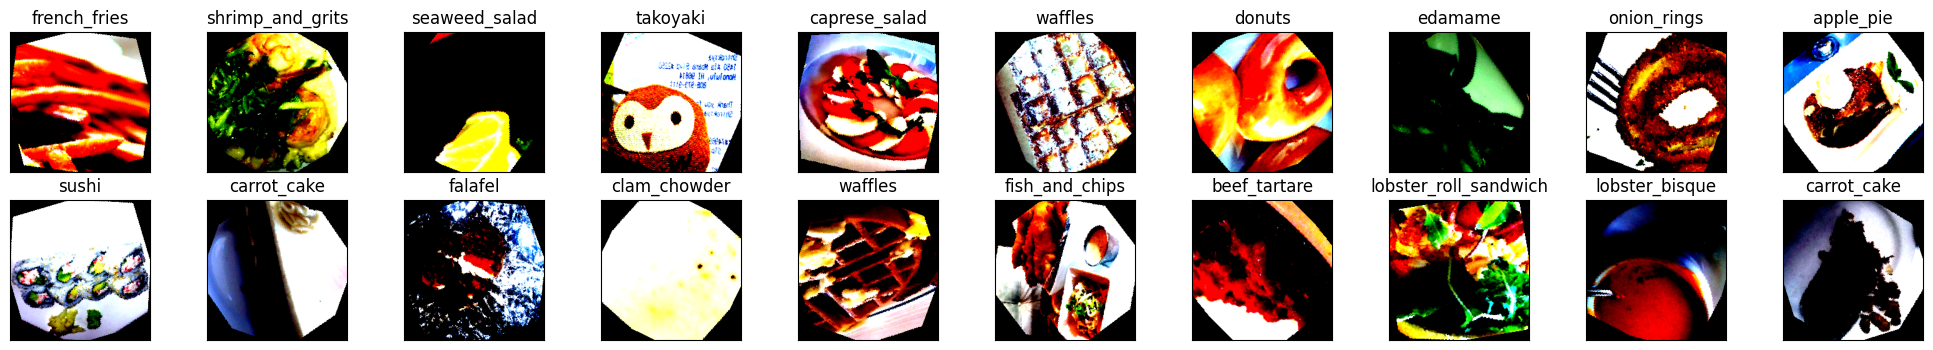

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])


LOADING RESNET 50

In [ ]:
model = models.resnet50(pretrained=True)
print(model)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 160MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Freeze the initial layers
for param in model.parameters():
  param.requies_grad = False

# Replace the final fully connected layer with new fully connected layer (randomly initialized weights)
# that outputs 101 units (based on our dataset)
classifier = nn.Linear(2048, 101)
model.fc = classifier
print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent with momentum)
optimizer = optim.SGD(model.fc.parameters(), lr=0.01, momentum=0.9)

# secify learning rate scheduler (if there is no further decrease in loss for next 5 epochs
# then lower the learning rate by 0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5)



In [ ]:
if train_on_gpu:
    model.cuda()

# number of epochs to train the model
n_epochs = 6

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):
    # keep track of training and validation loss
    train_loss = 0.0
    train_accuracy = 0.0
    valid_loss = 0.0
    val_accuracy = 0.0

    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        # Calculate training accuracy
        top_p, top_class = output.topk(1, dim=1)
        equals = top_class == target.view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()*data.size(0)

    ######################
    # validate the model #
    ######################
    model.eval()
    with torch.no_grad():
        for data, target in test_loader:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            ## For 10-crop Testing
            input_var = torch.autograd.Variable(data, volatile=True)
            target_var = torch.autograd.Variable(target, volatile=True)
            bs, ncrops, c, h, w = input_var.size()
            # forward pass: compute predicted outputs by passing inputs to the model
            temp_output = model(input_var.view(-1, c, h, w))
            output = temp_output.view(bs, ncrops, -1).mean(1)
            # calculate the batch loss
            loss = criterion(output, target_var)
            # update average validation loss
            valid_loss += loss.item()*data.size(0)
            # Calculate validation accuracy
            top_p, top_class = output.topk(1, dim=1)
            equals = top_class == target.view(*top_class.shape)
            val_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()*data.size(0)

    # calculate average losses and accuracies
    train_loss = train_loss/len(train_loader.dataset)
    train_accuracy = train_accuracy/len(train_loader.dataset)
    valid_loss = valid_loss/len(test_loader.dataset)
    val_accuracy = val_accuracy/len(test_loader.dataset)
    # Learning rate scheduler step
    scheduler.step(valid_loss)

    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.4f} \tTraining Accuracy: {:.4f} \tValidation Loss: {:.4f} \tValidation Accuracy: {:.4f}'.format(
        epoch, train_loss, train_accuracy, valid_loss, val_accuracy))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))

        checkpoint = {"model": model,
                      "criterion": criterion,
                      "epochs": epoch,
                      "optimizer_state": optimizer.state_dict(),
                      "model_state": model.state_dict(),
                      "valid_loss_min": valid_loss}

        # save model in colab
        torch.save(checkpoint, 'res50_model_checkpoint.pth')
        valid_loss_min = valid_loss

<ipython-input-22-ac4cb2b221ec>:52: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  input_var = torch.autograd.Variable(data, volatile=True)
<ipython-input-22-ac4cb2b221ec>:53: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  target_var = torch.autograd.Variable(target, volatile=True)


Epoch: 1 	Training Loss: 3.1819 	Training Accuracy: 0.2736 	Validation Loss: 2.3573 	Validation Accuracy: 0.4223
Validation loss decreased (inf --> 2.357336).  Saving model ...
Epoch: 2 	Training Loss: 2.7652 	Training Accuracy: 0.3486 	Validation Loss: 2.2141 	Validation Accuracy: 0.4495
Validation loss decreased (2.357336 --> 2.214067).  Saving model ...
Epoch: 3 	Training Loss: 2.6808 	Training Accuracy: 0.3634 	Validation Loss: 2.1112 	Validation Accuracy: 0.4680
Validation loss decreased (2.214067 --> 2.111234).  Saving model ...
Epoch: 4 	Training Loss: 2.6346 	Training Accuracy: 0.3760 	Validation Loss: 2.1184 	Validation Accuracy: 0.4662
Epoch: 5 	Training Loss: 2.6148 	Training Accuracy: 0.3772 	Validation Loss: 2.0448 	Validation Accuracy: 0.4890
Validation loss decreased (2.111234 --> 2.044751).  Saving model ...
Epoch: 6 	Training Loss: 2.5797 	Training Accuracy: 0.3865 	Validation Loss: 2.0413 	Validation Accuracy: 0.4836
Validation loss decreased (2.044751 --> 2.041287). 

In [ ]:
# Load the saved model from last checkpoint
checkpoint = torch.load("res50_model_checkpoint.pth", map_location='cpu')

# Use the same architecture as used earlier
model = models.resnet50(pretrained=False)
for param in model.parameters():
  param.requires_grad = False


classifier = nn.Linear(2048, 101)
model.fc = classifier

model.load_state_dict(checkpoint['model_state'], strict=False)

# specify loss function (categorical cross-entropy) same as used earlier
criterion = nn.CrossEntropyLoss()

# specify optimizer same as used earlier
optimizer = optim.SGD(model.fc.parameters(), lr=0.01, momentum=0.9)

# secify scheduler same as used earlier
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5)

# Check the saved model's last epoch and last validation loss
valid_loss = checkpoint["valid_loss_min"]
num_epoch = checkpoint['epochs']

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:

print(valid_loss)



2.0412872408687477


In [ ]:
checkpoint = torch.load("./res50_model_checkpoint.pth", map_location='cpu')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
with open('food-101/meta/classes.txt', 'r') as txt:
    classes = [l.strip() for l in txt.readlines()]

# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))

#move model to gpu
model.cuda()
model.eval()

# iterate over test data
with torch.no_grad():
  for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
      data, target = data.cuda(), target.cuda()

      ## For 10-crop Testing
      bs, ncrops, c, h, w = data.size()
      # forward pass: compute predicted outputs by passing inputs to the model
      temp_output = model(data.view(-1, c, h, w))
      output = temp_output.view(bs, ncrops, -1).mean(1)
      # calculate the batch loss
      loss = criterion(output, target)
      # update average test loss
      test_loss += loss.item()*data.size(0)
      # convert output probabilities to predicted class
      _, pred = torch.max(output, 1)
      # compare predictions to true label
      correct_tensor = pred.eq(target.data.view_as(pred))
      correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
      # calculate test accuracy for each object class
      for i in range(len(target)):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %.2f%% (%2d/%2d)' % (classes[i], 100 * class_correct[i] / class_total[i],
                                                         np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %.2f%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total),
                                                      np.sum(class_correct), np.sum(class_total)))



Test Loss: 2.041287

Test Accuracy of apple_pie: 0.40% ( 1/250)
Test Accuracy of baby_back_ribs: 80.00% (200/250)
Test Accuracy of baklava: 37.60% (94/250)
Test Accuracy of beef_carpaccio: 27.60% (69/250)
Test Accuracy of beef_tartare: 73.20% (183/250)
Test Accuracy of beet_salad: 14.00% (35/250)
Test Accuracy of beignets: 76.80% (192/250)
Test Accuracy of bibimbap: 66.80% (167/250)
Test Accuracy of bread_pudding: 4.00% (10/250)
Test Accuracy of breakfast_burrito: 14.40% (36/250)
Test Accuracy of bruschetta: 26.80% (67/250)
Test Accuracy of caesar_salad: 9.20% (23/250)
Test Accuracy of cannoli: 72.80% (182/250)
Test Accuracy of caprese_salad: 32.00% (80/250)
Test Accuracy of carrot_cake: 30.40% (76/250)
Test Accuracy of ceviche: 56.40% (141/250)
Test Accuracy of cheesecake: 31.60% (79/250)
Test Accuracy of cheese_plate: 23.20% (58/250)
Test Accuracy of chicken_curry: 23.20% (58/250)
Test Accuracy of chicken_quesadilla: 38.80% (97/250)
Test Accuracy of chicken_wings: 53.60% (134/250)
Te